In [29]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("IndividualTask_Smoting_MingyuGao.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 269


# Imbalance task - Mingyu Gao
# Group Num - 29
# Student Num - 5216281

This privacy aims at addressing the under-sampling problem of raw data. The theory of smote is to generate new samples based on the nearest neighbours of the original sample. This task mainly includes following work:
1. Data preprocessing: encoding and splitting raw data;
2. Constructing Smote: designing the smote algorithm to generate samples based on its k nearest neighbours;
3. Applying Smote: using three classifiers - Random Forest, Gussian NB and Decision Tree, to draw ROC curves for results of models trained by smoted and unsmoted train set;
4. Result Analysis: analyzing performace of the classifier from the perspective of three models and (un)smoted train set.

# Setup

In [28]:
from jupyterthemes import jtplot
import numpy as np
import pandas as pd

import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
jtplot.style('grade3')

# Load Data 

In [3]:
df = pd.read_csv('./data_for_student_case.csv')
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


# Data Preprocessing

In [4]:
# Delete the type of simple_journal - refused
df_new = df[df['simple_journal'] != 'Refused'].copy()
type_name, type_count = np.unique(df_new['simple_journal'], return_counts=True)

In [5]:
# Encoding data

In [6]:
# Encoding features that are renamed
# 1.label
df_new['label'] = df['simple_journal'].apply(
    lambda x: 1 if x == 'Chargeback' else 0)

# 2.creationdate
df_new['creationdate'] = pd.to_datetime(df_new['creationdate'])
df_new['creationdate'] = df_new['creationdate'].dt.date
date_enc = LabelEncoder()
date_enc.fit(df_new['creationdate'])
df_new['date'] = date_enc.transform(df_new['creationdate'])

# 3.converting different currency to a homogeneous value - measured in euros
to_euro = {
    'AUD': 0.64147,
    'GBP': 1.1494,
    'MXN': 0.04169,
    'NZD': 0.59499,
    'SEK': 0.09859
}


def amount_to_euro(df_colums):
    amount, currency = df_colums
    return to_euro[currency] * amount / 100


df_new['euroAmount'] = df_new[['amount', 'currencycode']].apply(
    amount_to_euro, axis=1)

# 4. aggregation for cvcresponse code
df_new['cvcRes'] = df_new['cvcresponsecode'].apply(
    lambda x: 3 if (x >= 3 and x < 6) else x)

# encoding for other features
# original features' names
col_ori = ['txvariantcode', 'issuercountrycode', 'accountcode', 'shopperinteraction',
           'shoppercountrycode']
# new features' names
col_new = ['txCode', 'issuerCountry', 'account', 'interaction',
           'shopperCountry']
label_encoder = LabelEncoder()
for col in range(0, len(col_ori)):
    df_new[col_new[col]] = label_encoder.fit_transform(
        df_new[col_ori[col]].astype(str))
# encoding for other features that do not need rename
column_list = [
    'bin',
    'shoppercountrycode',
    'cardverificationcodesupplied',
    'mail_id',
    'ip_id',
    'card_id',
    'date']
for col in column_list:
    df_new[col] = label_encoder.fit_transform(df_new[col].astype(str))

In [7]:
# delete uncoded features
df_unsmote = df_new.drop(['txid', 'txvariantcode', 'cvcresponsecode', 'shoppercountrycode',
 'bookingdate', 'issuercountrycode','amount', 'shopperinteraction',
 'simple_journal','creationdate', 'accountcode','currencycode'], axis ='columns')

In [8]:
df_unsmote.head()

,bin,cardverificationcodesupplied,mail_id,ip_id,card_id,label,date,euroAmount,cvcRes,txCode,issuerCountry,account,interaction,shopperCountry
0,1998,1,187702,7386,73358,1,0,27.01512,0,2,76,1,1,98
1,2364,1,834,194109,44739,1,1,18.71881,0,2,76,1,1,98
2,1965,1,119287,189655,122802,1,1,62.49331,0,2,76,1,1,98
3,2374,1,173561,8254,70712,1,35,45.81731,0,2,76,1,1,98
4,1301,1,70647,196247,208481,1,90,37.47931,0,6,76,1,1,98


# Data Splitting

In [9]:
# obtain the labels and features of data
df_unsmote_label = df_unsmote['label'].copy() # all labels
df_unsmote_feature = df_unsmote.drop(['label'], axis ='columns') # all features

In [10]:
# This splitting is for generating smoted train set 
# as our smote function cannot automatically identify the minority data
# splitting train_set and test_set at 80% and 20% (including features and labels)
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(
    df_unsmote, test_size=0.2, random_state=42)
print("Number of rows in train_set " + str(len(train_set)))
print("Number of rows in test_set " + str(len(test_set)))

Number of rows in train_set 189628
Number of rows in test_set 47408


In [11]:
# split fraud and benign cases in train set for smoting
fraud_data = train_set.loc[train_set['label'] == 1]
benign_data = train_set.loc[train_set['label'] == 0]
print("Number of rows in trainset_fraud_data " + str(len(fraud_data)))
print("Number of rows in trainset_benign_data " + str(len(benign_data)))

Number of rows in trainset_fraud_data 270
Number of rows in trainset_benign_data 189358


In [12]:
# deleting labels in fraud cases
fraud_data = fraud_data.drop(['label'], axis ='columns')

In [13]:
# This splitting is for train classifiers
# spliting x and y axis for trainset and testset for classifier
x_train_set, x_test_set, y_train_set, y_test_set = train_test_split(df_unsmote_feature, df_unsmote_label, test_size=0.2, random_state=42)

# Function for Plotting ROC Curves
This part we design the function of drawing ROC curves - a graphical plot that illustrates the diagnostic ability of a binary classifier.

In [14]:
# function for plotting ROC
from sklearn.metrics import roc_curve, roc_auc_score
def return_roc(model, x_train, y_train, x_test, y_test, normalize=True):
    # train set for training models
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)    
    return fpr, tpr, auc

# Implementing Smote Function

In [15]:
# building smote
from sklearn.neighbors import NearestNeighbors
import random
def smote(minority_for_smoting, k):
    '''
    minority_for_smoting: pandas dataframe
    k: the sampling rate
    
    return: smoted dataframe 
    '''
# k - sampling rate
    # T - Number of minority class samples
    T = len(minority_for_smoting)
    # cols - Column number of minority class samples
    n_features = len(minority_for_smoting.columns)
    # find the nearest k + 1 neighbours
    # number of neighbours > sampling rate
    nbrs = NearestNeighbors(n_neighbors = k+1, algorithm = 'auto').fit(minority_for_smoting)
    # distance : Array representing the lengths to points
    # indices: Indices of the nearest points in the population matrix
    distances, indices = nbrs.kneighbors(minority_for_smoting)
    nnarray = []
    data_array = [i for i in range(0,T * k)]
    # generating a matric for storing synthetic samples
    synthetic = pd.DataFrame(np.nan, index = data_array, columns = minority_for_smoting.columns)
    n = 0
    for i in range(len(indices)):
        # nnarray: storing the k+1 nearest neighbours
        for index in indices[i]:
            if index != i:
                nnarray.append(index)
        # choose a neighbour from the nearest k neighbours
        for k in nnarray:
            for m in range(0,n_features):
                # calculating the difference between the sample[k] to its neighbour [i]
                diff = np.subtract(minority_for_smoting.iloc[k, m], minority_for_smoting.iloc[i, m], dtype = np.float32)               
                # generating a new sample
                gap = random.uniform(0,1)
                synthetic.iloc[n, m] = minority_for_smoting.iloc[i, m] + (gap * diff)
            n += 1
        nnarray = []   
    smoted_data = minority_for_smoting.append(synthetic, ignore_index = True)    
    return smoted_data

In [16]:
# implement smote by ourselves to enlarge the fraud cases five times
smoted_fraud = smote(fraud_data,5)
print(str(len(smoted_fraud))) # check the new fraud cases

1620


In [17]:
# add labels to the smoted fraud cases
smoted_fraud["label"] = np.ones(len(smoted_fraud)) # add labels for the smoted ones
smoted_fraud.head() 

,bin,cardverificationcodesupplied,mail_id,ip_id,card_id,date,euroAmount,cvcRes,txCode,issuerCountry,account,interaction,shopperCountry,label
0,1965.0,1.0,36120.0,186037.0,140354.0,3.0,83.33831,0.0,2.0,76.0,1.0,1.0,98.0,1.0
1,1052.0,1.0,139536.0,188243.0,128963.0,14.0,246.96595,0.0,10.0,7.0,0.0,1.0,8.0,1.0
2,2032.0,1.0,153807.0,38930.0,134360.0,59.0,218.09980,0.0,2.0,7.0,0.0,1.0,8.0,1.0
3,1504.0,1.0,120226.0,181227.0,35124.0,82.0,279.03945,0.0,6.0,7.0,0.0,1.0,8.0,1.0
4,940.0,1.0,31164.0,101287.0,39450.0,19.0,36.72333,1.0,8.0,40.0,3.0,1.0,47.0,1.0


In [18]:
# merge smoted fraud cases and benign cases
frames = [smoted_fraud, benign_data]
smoted_trainset = pd.concat(frames, sort=False)
print("length of merged: " + str(len(smoted_trainset)))

length of merged: 190978


In [19]:
# spliting smoted labels and features for the following three classfier
smoted_labels = smoted_trainset['label'].copy()  # smoted train set's abels
smoted_features = smoted_trainset.drop(['label'], axis ='columns') # smoted train set's features

# Classifier

In [20]:
# 1. Random Forest
from sklearn.ensemble import RandomForestClassifier
## constructing Random Forest classifier
clf1 = RandomForestClassifier(n_estimators= 200, max_depth=10) 

Unsmoted AUC = 0.9468325833280515 Smoted AUC = 0.9453327136106593


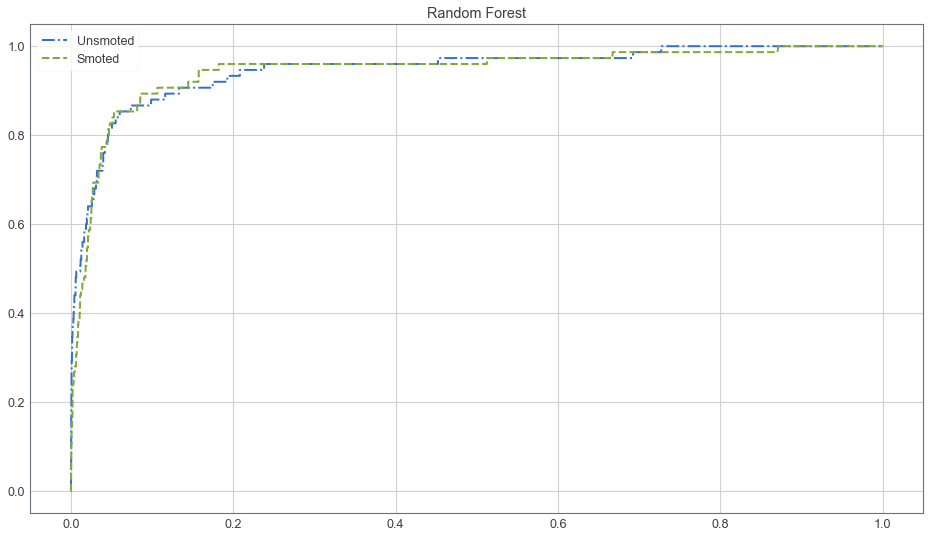

In [21]:
## plot format
plt.figure(figsize = (16,9))
## get fpr, tpr and auc values of models trained by unsmoted data
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf1, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
## get fpr, tpr and auc values of models trained by smoted data
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf1, smoted_features, smoted_labels, x_test_set, y_test_set)
## drawing the ROC curves of results of models trained by unsmoted and smoted trainset
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
## print the AUC values of results of models trained by unsmoted and smoted trainset
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Random Forest")
plt.show()

In [22]:
# 2. Gussian NB
from sklearn.naive_bayes import GaussianNB
## constructing classifier
clf2 = GaussianNB()

Unsmoted AUC = 0.8469890633032627 Smoted AUC = 0.8478518862808894


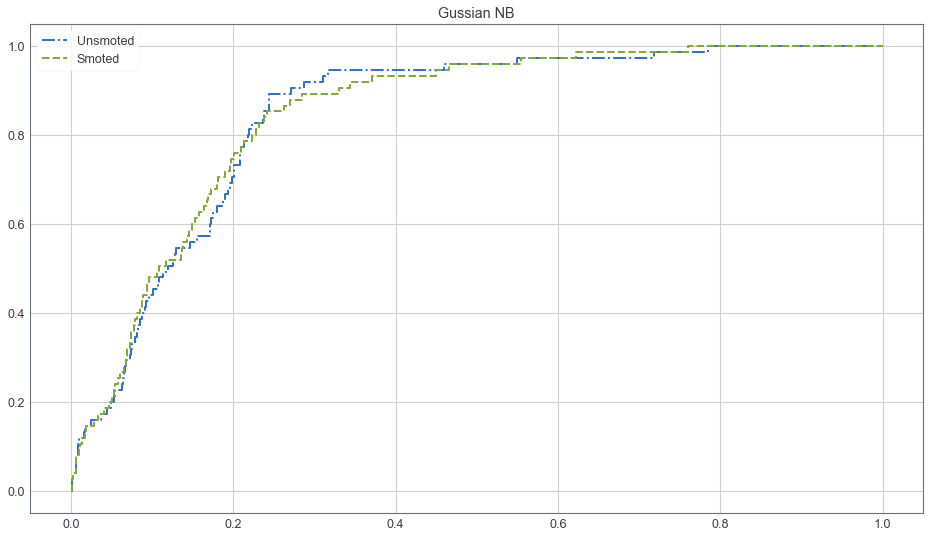

In [23]:
plt.figure(figsize = (16,9))
## get fpr, tpr and auc values of models trained by unsmoted data
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf2, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
## get fpr, tpr and auc values of models trained by smoted data
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
## drawing the ROC curves of results of models trained by unsmoted and smoted trainset
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
## print the AUC values of results of models trained by unsmoted and smoted trainset
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Gussian NB")
plt.show()

In [24]:
# 3. Decision Tree
from sklearn import tree
clf3 = tree.DecisionTreeClassifier(splitter='random', max_depth = 10)

Unsmoted AUC = 0.7567240614370524 Smoted AUC = 0.8387474559679997


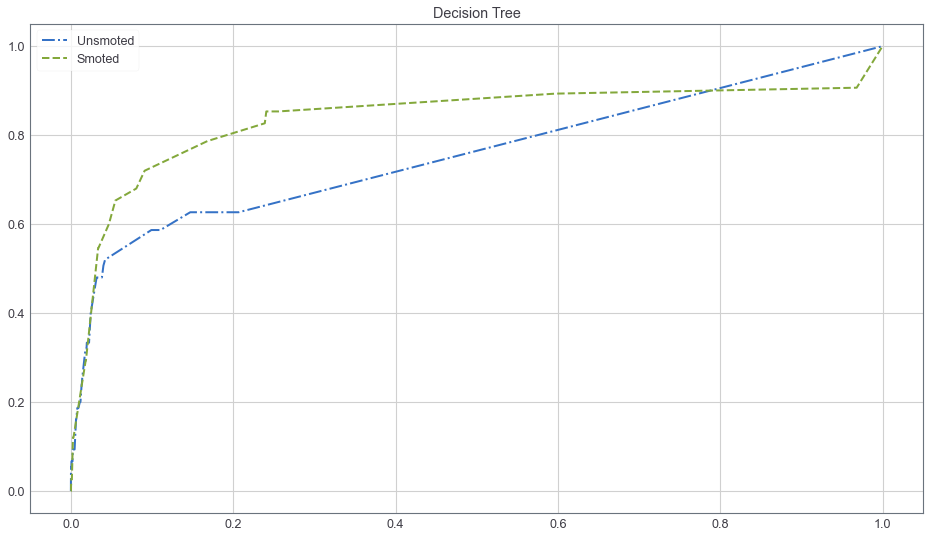

In [25]:
plt.figure(figsize = (16,9))
## get fpr, tpr and auc values of models trained by unsmoted data
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf3, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
## get fpr, tpr and auc values of models trained by smoted data
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf3, smoted_features, smoted_labels, x_test_set, y_test_set)
## drawing the ROC curves of results of models trained by unsmoted and smoted trainset
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
## print the AUC values of results of models trained by unsmoted and smoted trainset
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Decision Tree")
plt.show()

# Comparison for three classifers after smoting

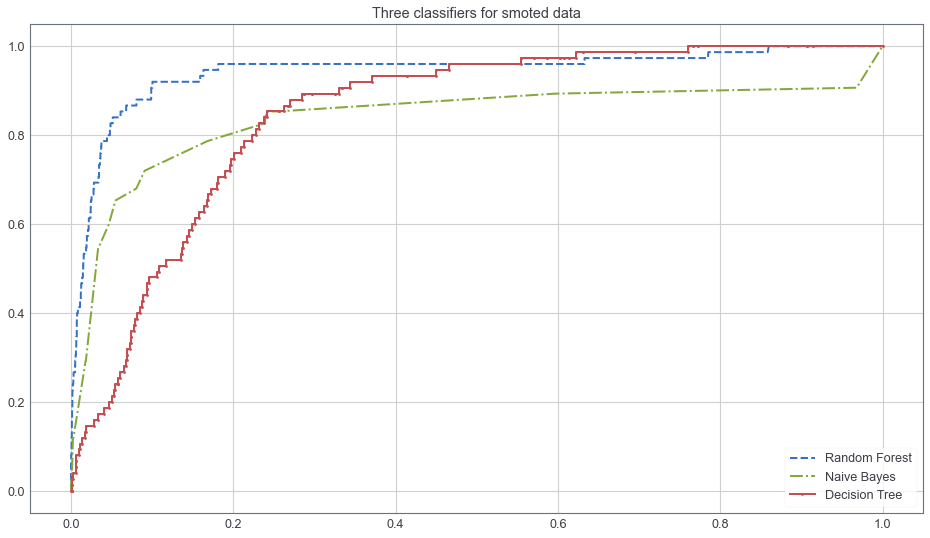

In [26]:
# draw three ROC curves of models trained by smoted trainset in one plot
plt.figure(figsize = (16,9))
smoted_fpr1, smoted_tpr1, smoted_auc1 = return_roc(clf1, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr1, smoted_tpr1,"--", label='Random Forest', linewidth=2)

smoted_fpr2, smoted_tpr2, smoted_auc2 = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr, smoted_tpr,"-.", label='Naive Bayes', linewidth=2)

smoted_fpr3, smoted_tpr3, smoted_auc3 = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr3, smoted_tpr3,".-", label='Decision Tree', linewidth=2)
plt.legend(['Random Forest', 'Naive Bayes', 'Decision Tree'])
plt.title("Three classifiers for smoted data")
plt.show()

# Analyse the performance of the classifiers. Explain which method performs best.

The accurate of a classifier can be reflected by the area composed by the ROC curve and x-axis. Based on the three ROC curves of smoted data, we can see that Random Forest classifier performs best among the three classifies. 

# Is using SMOTE a good idea? Why (not)?

Yes. 

Considering that AUC values in all three classifiers when using smoted data for all the 3 classifiers used above and the area of smoted ROC curve expands when applying decision tree, we can say that smoting data before applying classifiers gives a better train set to work with.